**This notebook is intended to show the results of the app with an increasing number of processes as well as with different parameters. There is no explanations of the application.**

# 5. HPC PDE Solver - The results

In [1]:
import ipyparallel as ipp
rc = ipp.Client()
view = rc[:]

In [2]:
%%px

from mpi4py import MPI
import numpy as np
import math
import time
import matplotlib.pyplot as plt

### The Discretization object

In [3]:
%%px

class Discretization: 
    
    def __init__(self, nx, ny, nt, t, d=1.0, r=1000.0, v=0, ic=None):
        self.nx = int(nx)                             # x dimension (Number of HORIZONTAL grid points) (int)
        self.ny = int(ny)                             # y dimension (Number of VERTICAL grid points) (int)
        self.nt = int(nt)                             # number of time steps (int)
        self.dx = 1.0 / (nx - 1)                      # distance between each grid points (vertically and horizontally) (double)
        self.dt = t / nt                              # time step size (double)
        self.d = d                                    # the diffusion coefficient D (double)
        self.r = r                                    # the reaction coefficient R (double)
        self.alpha = (self.dx**2)/(self.d * self.dt)  # dx^2/(D*dt) (double)
        self.beta = self.r * (self.dx**2) / self.d    # R*dx^2/D (double)
        
        # simulation parameters
        self.verbose_output = False      # if you want to print more informations during the simulation
        self.custom_init = False         # if the simulation has a customised initial condition
        
        # verbose output
        if v != 0:
            self.verbose_output = True 
        
        # we check that the points entered are valid for the customised initial condition
        # None is equivalent to False when evaluated in Python
        if ic: 
            for point in ic:
                    assert(point[0] >= 0 and point[0] < self.nx)  # checking x coordinate
                    assert(point[1] >= 0 and point[1] < self.ny)  # checking y coordinate
                    assert(point[2] >= 0.0 and point[2] <= 1.0)   # checking s value
            self.points = ic                                        # the custom initial condition is valid
            self.custom_init = True
       
        # statistics variables initialized
        self.flops_count = 0   # number of flops
        self.iters_cg = 0      # number of Conjugate Gradient iteration
        self.iters_newton = 0  # number of Newton iteration

### The Domain object

In [4]:
%%px

class Domain: 

    def create_dim(self, size):
        dividers = []
        for i in range(size - 1 , 0, -1):
            if (size%i == 0 and i != 1):
                dividers.append(i)
        if (dividers == []):
            return [size, 1]
        else: 
            divider = dividers[len(dividers) // 2]
            return [size // divider, divider]
    
    # constructor for the domain object
    def __init__(self, rank, size, discretization, communicator):

        # dimensions of the cartesian plan
        dims = self.create_dim(size)
        
        # save the dimension on each axis as an object attribute
        self.ndomy = dims[0]
        self.ndomx = dims[1]

        # generate the cartesian plan given the dimensions (mpi function)
        # no periodicity of the dimensions
        # no reordering
        comm_cart = communicator.Create_cart(dims, [False, False], False)
        
        # save the cartesian communication group as an object attribute
        self.comm_cart = comm_cart

        # get the coordinates of the current processor on the newly generated cartesian plan (mpi function)
        coords = self.comm_cart.Get_coords(rank)
        
        # save the coordinates as attributes
        self.domy = coords[0] # (int)
        self.domx = coords[1] # (int)
        
        # get the ranks of the domains neighbouring the current domain
        # .Shift(direction_on_cartesian_plan, size_of_the_shift)
        # row direction is 0 (x-direction)
        # column direction is 1 (y-direction)
        south_north = self.comm_cart.Shift(0, 1) # tuple (int, int)
        west_east = self.comm_cart.Shift(1, 1) # tuple (int, int)
    
        # save the rank of neighbouring domains as object attributes
        self.neighbour_south = south_north[0]
        self.neighbour_north = south_north[1]
        self.neighbour_west = west_east[0]
        self.neighbour_east = west_east[1]

        # number of horizontal and vertical grid points of the current domain
        self.nx = discretization.nx // self.ndomx # (int)
        self.ny = discretization.ny // self.ndomy # (int)

        # the starting coordinates of the current (sub)domain in the full grid
        # the coordinates start from 0
        self.startx = (self.domx) * self.nx # (int)
        self.starty = (self.domy) * self.ny # (int)

        # we adjust for grid dimensions that, potentially, do not divide evenly between the domains
        # we stretch the last element of each dimension to fit the remaining part
        # domx and domy start from 0 so we have to do (ndomx - 1) & (ndomy - 1)
        if self.domx == (self.ndomx - 1):
            self.nx = discretization.nx - self.startx
        if self.domy == (self.ndomy - 1):
            self.ny = discretization.ny - self.starty
        
        # the ending coordinates in the full grid of the current domain
        self.endx = self.startx + self.nx - 1 # (int)
        self.endy = self.starty + self.ny - 1 # (int)

        # the total number of grid points of the current domain
        self.n_total = self.nx * self.ny # (int)

        # mpi values for the current domain saved as object attributes
        self.rank = rank
        self.size = size
        
        # fields holding the solutions (Numpy matrices)
        self.x_new = np.zeros((self.ny, self.nx), dtype=np.float64) # solution at timestep k (2d)
        self.x_old = np.zeros((self.ny, self.nx), dtype=np.float64) # solution at timestep k-1 (2d)
       
        # fields holding the boundary points when they are received from the neighbouring domains
        self.bndN = np.zeros((1, self.nx), dtype=np.float64) # boundary north (1d)
        self.bndS = np.zeros((1, self.nx), dtype=np.float64) # boundary east (1d)
        self.bndE = np.zeros((1, self.ny), dtype=np.float64) # boundary south (1d)
        self.bndW = np.zeros((1, self.ny), dtype=np.float64) # boundary east (1d)

        # buffers used during boundaries communication
        # to send the boundary points of the current domain
        # to its neighbours
        self.buffN = np.zeros((1, self.nx), dtype=np.float64) # (1d)
        self.buffS = np.zeros((1, self.nx), dtype=np.float64) # (1d)
        self.buffE = np.zeros((1, self.ny), dtype=np.float64) # (1d)
        self.buffW = np.zeros((1, self.ny), dtype=np.float64) # (1d)
     
    # function for printing the parameters of the cartesian division among each process
    def print(self):
        # print, for each process, the domain object
        for i in range(0, self.size):
            if i == self.rank:  
                print("Rank " + str(self.rank) + "/" + str(self.size-1))
                print("At index (" + str(self.domy) + "," + str(self.domx) + ")")
                print("Neigh N:S " + str(self.neighbour_north) + ":" + str(self.neighbour_south))
                print("Neigh E:W " + str(self.neighbour_east) + ":" + str(self.neighbour_west))
                print("Coordinates startx:endx  " + str(self.startx) + ":" + str(self.endx))
                print("Coordinates starty:endy  " + str(self.starty) + ":" + str(self.endy))
                print("Local dims " + str(self.nx) + " x " + str(self.ny))
                print("")
            
            # keep the printing ordered and cleaned
            self.comm_cart.Barrier()
            # wait a bit when printing to avoid polluating other printed messages.
            time.sleep(0.1)

        return None

### The diffusion function

In [5]:
%%px

# the complete diffusion function
def diffusion(U, S, discretization, domain):
        
    # we create shortcuts for variables heavily used in the function
    alpha = discretization.alpha
    beta = discretization.beta
    nx = domain.nx
    ny = domain.ny
    comm_cart = domain.comm_cart

    # we initialize the lists for saving the mpi requests and statuses of the non-blocking functions in order to wait for them later
    # there should be a maximum of 8 requests if the domain is completely surrounded by neighbours
    statuses = [MPI.Status()] * 8
    requests = [MPI.Request()] * 8
    num_requests = 0 # current requests counter

    # !! The non-blocking communication !!

    # send the North boundary to the North neighbour if the current domain has a North neighbour
    if domain.neighbour_north >= 0:
        # wait for the south boundary of the Norht neighbour
        # set tag to be the sender's rank
        # .Irecv([np_array_received, type_of_members], rank_of_source, message_tag)
        # the request is returned and saved to wait for it after
        requests[num_requests] = comm_cart.Irecv([domain.bndN, MPI.DOUBLE], domain.neighbour_north, domain.neighbour_north)
        num_requests += 1

        # pack North buffer of the current domain to send it
        # the current domain makes use of the buffer object to send the array
        domain.buffN[0, :] = U[ny-1, :]
        
        # the current domain sends its North boundary which will be received as the South boundary by its North neighbour
        # .Isend([np_array_sent, type_of_members], rank_of_destination, message_tag)
        requests[num_requests] = comm_cart.Isend([domain.buffN, MPI.DOUBLE], domain.neighbour_north, domain.rank)
        num_requests += 1
    
    # same logic for South boundary if there is a South neighbour
    if domain.neighbour_south >= 0:

        requests[num_requests] = comm_cart.Irecv([domain.bndS, MPI.DOUBLE], domain.neighbour_south, domain.neighbour_south)
        num_requests += 1

        domain.buffS[0, :] = U[0, :]

        requests[num_requests] = comm_cart.Isend([domain.buffS, MPI.DOUBLE], domain.neighbour_south, domain.rank)  
        num_requests += 1

    # same logic for East boundary if there is a East neighbour
    if domain.neighbour_east >= 0:

        requests[num_requests] = comm_cart.Irecv([domain.bndE, MPI.DOUBLE], domain.neighbour_east, domain.neighbour_east)
        num_requests += 1
        
        domain.buffE[0, :] = U[:, nx-1]
    
        requests[num_requests] = comm_cart.Isend([domain.buffE, MPI.DOUBLE], domain.neighbour_east, domain.rank)  
        num_requests += 1

    # same logic for West boundary if there is a West neighbour
    if domain.neighbour_west >= 0:
        
        requests[num_requests] = comm_cart.Irecv([domain.bndW, MPI.DOUBLE], domain.neighbour_west, domain.neighbour_west)
        num_requests += 1
        
        domain.buffW[0, :] = U[:, 0]

        requests[num_requests] = comm_cart.Isend([domain.buffW, MPI.DOUBLE], domain.neighbour_west, domain.rank) 
        num_requests += 1
    
    # ----------------------------------------------------------------------
    # while waiting for the non-blocking communications to proceed
    # we can calculate the interior grid points
    # it makes the process more efficient by reducing the overhead
    # of waiting for the communications to proceed (if it was blocking communications)
    # ----------------------------------------------------------------------
    
    # we initialize the value for the slice operator to avoid repeating calculation
    srow = domain.ny - 1
    scol = domain.nx - 1
    
    # interior grid points (refer to the formula of the function f_{i, j}^{k})
    S[1:srow, 1:scol] = ( -(4.0 + alpha) * U[1:srow, 1:scol] 
                        + U[1-1:srow-1, 1:scol] + U[1+1:srow+1, 1:scol] 
                        + U[1:srow, 1-1:scol-1] + U[1:srow, 1+1:scol+1]
                        + beta * U[1:srow, 1:scol] * (1.0 - U[1:srow, 1:scol]) 
                        + alpha * domain.x_old[1:srow, 1:scol] )

    # waiting for all the non-blocking communications to succeed before calculating the boundaries
    # .Waitall takes a list of requests to wait for and a list of statuses to update when the requests succeed
    MPI.Request.Waitall(requests, statuses)

    # East boundary
    # ---------------
    
    # slice operator initialized
    srow = domain.ny - 1
    scol = domain.nx - 1
    
    # East boudary calculation
    S[1:srow, scol] = ( -(4.0 + alpha) * U[1:srow, scol]
                        + U[1-1:srow-1, scol] + U[1+1:srow+1, scol] 
                        + U[1:srow, scol-1] + domain.bndE[0, 1:srow]
                        + beta * U[1:srow, scol] * (1.0 - U[1:srow, scol])
                        + alpha * domain.x_old[1:srow, scol]  )
    
    # West boundary
    # ---------------
    
    # slice operator initialized
    srow = domain.ny - 1
    scol = 0
    
    # West boundary calculation
    S[1:srow, scol] = ( -(4.0 + alpha) * U[1:srow, scol]
                        + U[1:srow, scol+1] + U[1-1:srow-1, scol] + U[1+1:srow+1, scol]
                        + alpha * domain.x_old[1:srow, scol] + domain.bndW[0, 1:srow]
                        + beta * U[1:srow, scol] * (1.0 - U[1:srow, scol]) )
    
    # North boundary
    # ---------------
    
    # slice operator
    srow = domain.ny - 1
    
    # North-West corner (which needs the value of the two neighbouring domains on the North and on the West)
    scol = 0
    S[srow, scol] = ( -(4.0 + alpha) * U[srow, scol]
                        + U[srow-1, scol] + domain.bndN[0][scol] 
                        + domain.bndW[0, srow] + U[srow, scol+1]
                        + beta * U[srow, scol] * (1.0 - U[srow, scol])
                        + alpha * domain.x_old[srow, scol])
    
    # North boundary
    scol = domain.nx - 1
    S[srow, 1:scol] = ( -(4.0 + alpha) * U[srow, 1:scol]
                        + U[srow, 1-1:scol-1] + U[srow, 1+1:scol+1] + U[srow-1, 1:scol]
                        + alpha * domain.x_old[srow, 1:scol] + domain.bndN[0, 1:scol]
                        + beta * U[srow, 1:scol] * (1.0 - U[srow, 1:scol]) )
    
    # North-East corner
    scol = domain.nx - 1
    S[srow, scol] = ( -(4.0 + alpha) * U[srow, scol]
                        + U[srow, scol-1] + U[srow-1, scol]
                        + alpha * domain.x_old[srow, scol] + domain.bndE[0, srow] + domain.bndN[0, scol]
                        + beta * U[srow, scol] * (1.0 - U[srow, scol]) )

    # South boundary
    # ---------------
    
    # slice operator
    srow = 0
    
    # South-West corner
    scol = 0
    S[srow, scol] = ( -(4.0 + alpha) * U[srow, scol]
                        + U[srow, scol+1] + U[srow+1, scol]
                        + alpha * domain.x_old[srow, scol] + domain.bndW[0, srow] + domain.bndS[0, scol]
                        + beta * U[srow, scol] * (1.0 - U[srow, scol]) )
    
    # South boundary
    scol = domain.nx - 1
    S[srow, 1:scol] = ( -(4.0 + alpha) * U[srow, 1:scol]
                        + U[srow, 1-1:scol-1] + U[srow, 1+1:scol+1] + U[srow+1, 1:scol]
                        + alpha * domain.x_old[srow, 1:scol] + domain.bndS[0, 1:scol]
                        + beta * U[srow, 1:scol] * (1.0 - U[srow, 1:scol]) )

    # South-East corner
    scol = domain.nx - 1
    S[srow, scol] = ( -(4.0 + alpha) * U[srow, scol]
                        + U[srow, scol-1] + U[srow+1, scol]
                        + alpha * domain.x_old[srow, scol] + domain.bndE[0, srow] + domain.bndS[0, scol]
                        + beta * U[srow, scol] * (1.0 - U[srow, scol]) )

    # Statistics (for printing at the end)
    # flop counts
    # 8 flops per point
    discretization.flops_count += (
            + 12 * (nx - 2) * (ny - 2)  # interior points
            + 11 * (nx - 2  +  ny - 2)  # boundaries points
            + 11 * 4 )                  # corner points

### The norm function

In [6]:
%%px

# this function compute the norm and broadcast it to all the other processes so that each process has the same norm
def norm(b, domain): 
    
    # Numpy array initialized
    result = np.zeros((1), dtype=np.float64) # intermediate result per process
    global_result = np.zeros((1), dtype=np.float64) # global (concatenated) result

    # sum of the elements of b to the power of 2
    # b**2 is the fastest way to put b to the power of 2 with Numpy
    result[0] += np.sum(b**2)
    
    # sum up the intermediate result of each process and broadcast it to the global_result variable of each of them
    # .Allreduce([result_of_each_proc_to_sum, type], [variable_holding_summed_results, type], operation_to_concatenate_result)
    domain.comm_cart.Allreduce([result, MPI.DOUBLE], [global_result, MPI.DOUBLE], op=MPI.SUM)
        
    # the final global sum is squared and returned, each process will have the same norm
    return math.sqrt(global_result)

### The dot function

In [7]:
%%px

# compute the dot product of two vectors and broadcast it to all the other processes so that each process has the same dot
def dot(x, y, domain):

    result = np.zeros((1), dtype=np.float64)
    global_result = np.zeros((1), dtype=np.float64)
   
    result[0] = np.dot(x, y)
    
    domain.comm_cart.Allreduce([result, MPI.DOUBLE], [global_result, MPI.DOUBLE], op=MPI.SUM)

    return global_result

### The CGVariables object

In [8]:
%%px

# variables for the Conjugate Gradient solving function
# this object has to be initialized just once before the very first iteration of the conjugate gradient
class CGVariables:
    
    def __init__(self, ny, nx):
        self.r = np.zeros((ny, nx), dtype=np.float64)      # r (residual)
        self.p = np.zeros((ny, nx), dtype=np.float64)      # p
        self.Ap = np.zeros((ny, nx), dtype=np.float64)     # A * p
        self.Fx = np.zeros((ny, nx), dtype=np.float64)     # field used for the matrix-free procedure (for getting A*p)
        self.Fxold = np.zeros((ny, nx), dtype=np.float64)  # field used for the matrix-free procedure (for getting A*p)
        self.v = np.zeros((ny, nx), dtype=np.float64)      # field used for the matrix-free procedure (for getting A*p)
        self.xold = np.zeros((ny, nx), dtype=np.float64)   # field used for the matrix-free procedure (for getting A*p)

### The matrix-free CG solver function

In [9]:
%%px

# conjugate gradient solver
# solve the linear system A*x = b for x
# the matrix A is approximating using the matrix-free product vector multiplication in the procedure
# the matrix b comes from the diffusion of x_new
# on entry x contains the initial guess for the solution
# on exit x contains the solution
def cg_solver(x, b, maxiters, tol, discretization, domain, cgv): 
    
    # Extract from the cvg object created and passed as parameter
    # (create shortcuts)
    r = cgv.r
    p = cgv.p
    Ap = cgv.Ap   
    Fx = cgv.Fx
    Fxold = cgv.Fxold
    v = cgv.v
    xold = cgv.xold
    
    # variables used for the matrix-vector approximation of the Jacobian
    eps = 1.e-8
    eps_inv = 1./ eps
    
    # copy the previous value of x
    xold[:] = x
    
    # r = b - Ax
    # we approximate Ax using a matrix-vector approximation technique which gives us the Ax vector directly
    # without having to calculate explicitly or store the Jacobian A
    # and then we do (b - Ax) to get r
    diffusion(x, Fxold, discretization, domain)
    v = x * (1.0 + eps)
    diffusion(v, Fx, discretization, domain)
    r = b - eps_inv * (Fx - Fxold)
    
    # p = r
    p[:] = r
    
    # old residual saved
    # rold = r' * r
    rold = dot(r.flatten(), r.flatten(), domain)
    rnew = rold
    
    # check for convergence condition
    success = False
    if math.sqrt(rold) < tol:
        success = True
        return success
    
    iteration = 0
    for iteration in range(0, maxiters): # maxiters passed as parameter of the function
        
        # Ap = A*p
        # again, we do a matrix-vector approximation of Ap using a matrix-free technique
        # we do not calculate Ap explicitly
        v = 1.0 * xold + eps * p
        diffusion(v, Fx, discretization, domain)
        Ap = eps_inv * (Fx - Fxold)

        # alpha = (r' * r) / (p' * Ap)
        alpha = rold / dot(p.flatten(), Ap.flatten(), domain)

        # x = x + alpha * p
        x += alpha * p

        # r = r - alpha * Ap
        r -= alpha * Ap

        # rnew = r' * r
        rnew = dot(r.flatten(), r.flatten(), domain)
            
        # check for convergence criterion
        if math.sqrt(rnew) < tol:
            success = True
            break

        # p = r + beta * p
        # p = r + (rnew/rold) * p
        p = r + (rnew/rold) * p

        # rold = rnew
        rold = rnew

    # statistics
    discretization.iters_cg += iteration + 1

    if not success:
        print("ERROR: CG failed to converge")

    return success

### The plotting function

In [10]:
%%px
%matplotlib inline

def plot_solution(discretization, domain):
    
    # Total nx and ny of the full grid
    tnx = discretization.nx 
    tny = discretization.ny

    # !! only blocking communication is used !!
    # ---------------------------------------

    # if rank != 0, the process will send the information and the solution to process 0
    if domain.rank != 0:
        info = np.array([domain.ny, domain.nx, domain.neighbour_east, domain.neighbour_north], dtype=np.int)
        domain.comm_cart.Send([info, MPI.INT], dest=0, tag=1)
        domain.comm_cart.Send([domain.x_old, MPI.DOUBLE], dest=0, tag=2)

    # if this is process 0, it will receive and place the solution of each domain
    # following the logic: All East neighbours - One North neighbour - All East neighbours - One North neighbour...
    if domain.rank == 0: 

        # initializing the final matrix holding the full solution
        result = np.zeros((tny, tnx), dtype=np.float64)

        # object for receiving the info of the other domains
        # [row, column, neigh_east, neigh_north]
        info = np.empty((4), dtype=np.int) 

        # append the rank 0's own solution
        result[0:domain.ny, 0:domain.nx] = domain.x_old

        # variables for the while loop
        # used for knowing the current neighbour in the North and in the East of the current domain processed
        current_neighbour_north = domain.neighbour_north
        current_neighbour_east = domain.neighbour_east

        # variables for the inner while loop
        # used for updating the place in the result matrix where the solution of the current
        # domain has to be placed
        rd = 0 # row => y dimension
        cd = 0 + domain.nx # column <=> x dimension

        # while there is a neighbour in the East
        while current_neighbour_east >= 0:

            # receive informations about the domain
            domain.comm_cart.Recv([info, MPI.INT], source=current_neighbour_east, tag=1)
            # initialize variable which will hold the solution of that domain
            sub_matrix = np.empty((info[0], info[1]), dtype=np.float64)
            # receive the domain solution
            domain.comm_cart.Recv([sub_matrix, MPI.DOUBLE], source=current_neighbour_east, tag=2)
            # place it on the result matrix using the informations
            result[rd:rd+info[0], cd:cd+info[1]] = sub_matrix

            # update placing and current East neighbour
            cd += info[1]
            current_neighbour_east = info[2]

        # update placing for potential North neighbour
        rd += domain.ny
        cd = 0

        # while there is a neighbour in the North
        while current_neighbour_north >= 0:

            # same principle as for East
            domain.comm_cart.Recv([info, MPI.INT], source=current_neighbour_north, tag=1)
            sub_matrix = np.empty((info[0], info[1]), dtype=np.float64)
            domain.comm_cart.Recv([sub_matrix, MPI.DOUBLE], source=current_neighbour_north, tag=2)
            result[rd:rd+info[0], cd:cd+info[1]] = sub_matrix

            # update informations
            cd += info[1]
            current_neighbour_east = info[2]
            current_neighbour_north = info[3]

            # while this North neighbour has itself East neighbours...
            while current_neighbour_east >= 0:

                # same logic...
                domain.comm_cart.Recv([info, MPI.INT], source=current_neighbour_east, tag=1)
                sub_matrix = np.empty((info[0], info[1]), dtype=np.float64)
                domain.comm_cart.Recv([sub_matrix, MPI.DOUBLE], source=current_neighbour_east, tag=2)
                result[rd:rd+info[0], cd:cd+info[1]] = sub_matrix

                cd += info[1]
                current_neighbour_east = info[2]

            rd += info[0]
            cd = 0

    # plotting the solution (result matrix)
    # the result matrix variable exists only in process 0
    if domain.rank == 0:
        # size of figure
        plt.figure(figsize=(10,8))
        # contour plot with line and a colorbar
        graph = plt.contourf(result, 12, alpha=.75, cmap='jet')
        plt.contour(result, 12, colors='black', linewidths=0.1)
        cbar = plt.colorbar(graph)
        cbar.set_label('Diffusion value')
        plt.title('Contour plot of the solution')
        plt.show()

## The main function

In [11]:
%%px

# the discretization object is passed as parameter
# the communicator is also passed to control the number of processes which constitutes the COMM_WORLD
def main(discretization, comm):

    # mpi initialization
    rank = comm.Get_rank()
    size = comm.Get_size()
    
    # domain object
    domain = Domain(rank, size, discretization, comm)

    # iteration parameters for Newton's method and Conjugate Gradient
    max_cg_iters     = 200
    max_newton_iters = 50
    tolerance     = 1.e-6

    # printing a message of beginning
    if domain.rank == 0:
        print("========================================================================")
        print("Welcome to mini-stencil!")
        print("Version   :: Python 3 with MPI4Py: " + str(domain.size) + " MPI ranks")
        print("Mesh      :: " + str(discretization.nx) + " * " + str(discretization.ny) + " dx = " + str(discretization.dx))
        print("Iteration :: " + "CG " + str(max_cg_iters) + ", Newton " + str(max_newton_iters) + ", tolerance " + str(tolerance))
        print("========================================================================")

    # printing the details of the cartesian division of the processors
    if domain.rank == 0: 
        print("Cartesian division details for each processor (subdomain)\n")
    domain.print()

    # printing the verbose output if the option is enabled
    if domain.rank == 0 and discretization.verbose_output: 
        print("========================================================================")
        print("Verbose output\n")

    # initialization of the b of Ax = b
    b = np.zeros((domain.ny, domain.nx), dtype=np.float64)

    # the CGVariables object
    cgvar = CGVariables(domain.ny, domain.nx)

    # initialization of the variable holding the solution for the conjugate gradient function
    deltax = np.zeros((domain.ny, domain.nx), dtype=np.float64)

    # Initial condition
    # -------------------

    # the customised initial condition if enabled
    if (discretization.custom_init):

        for i in discretization.points:

            x = i[0]
            y = i[1]
            s = i[2]

            if (x >= domain.startx and x <= domain.endx
                and y >= domain.starty and y <= domain.endy):
                x -= domain.startx
                y -= domain.starty

                domain.x_new[y, x] = s

    # the default initial condition
    else: 
        # A circle of concentration 0.1 centred at (xdim/4, ydim/4) 
        # with radius no larger than 1/8 of both xdim and ydim of the grid
        # x length is always one while y length depends on the dimensions passed
        xc = 1.0 / 4.0
        yc = (discretization.ny - 1) * discretization.dx / 4.0
        # min ensure that the radius of the circle will not be larger than 1/8 of xdim or ydim
        radius = min(xc, yc) / 2.0 

        # test every point to see if it is in the radius of the circle
        for j in range(domain.starty, domain.endy+1):

            # length in the y dimension
            y = (j) * discretization.dx

            for i in range(domain.startx, domain.endx+1):

                # length in the x dimension
                x = (i) * discretization.dx

                # test if the grid point made of (y, x) is inside the circle
                if ((x - xc) * (x - xc) + (y - yc) * (y - yc)) < (radius * radius):
                    domain.x_new[j - domain.starty][i - domain.startx] = 0.1

    # statistic: start time
    start_time = time.time()

    # Main timeloop
    # --------------

    for timestep in range(1, discretization.nt + 1):

        # x_old = x_new
        # the solution of the previous time step becomes the x_old
        domain.x_old[:] = domain.x_new 

        # new residual at each time step
        residual = 0.0
        converged = False

        # Newton's method loop
        it = 0
        for it in range (0, max_newton_iters):

            # we get the b in Ax = b by using the diffusion function
            # b = f(y^{l})
            diffusion(domain.x_new, b, discretization, domain)

            # residual of the Newton's method with the norm function of the linear algebra part
            residual = norm(b, domain) 

            # convergence criterion
            if residual < tolerance:
                converged = True
                break

            # solve the Ax = b where A is the Jacobian and x is deltax (we already have b)
            # again, A is approximated in the CG function, it does not need to be explicitly calculated
            cg_converged = cg_solver(deltax, b, max_cg_iters, tolerance, discretization, domain, cgvar)

            # check that the CG solver has converged
            if not cg_converged:
                break

            # y_{l+1} = y^{l} - deltax 
            # with the deltax got from the cg_solver function
            domain.x_new -= deltax

        # statistics: number of Newton's iteration
        discretization.iters_newton += it + 1

        # verbose mode: print time step and residual at each Newton's iteration
        if converged and discretization.verbose_output:
            print("Step " + str(timestep) + " required " + str(it) + " iterations for residual " + str(residual))

        # print error if the convergence of the Newton's method failed
        if not converged:
            print("Step " + str(timestep) + " ERROR : nonlinear iterations failed to converge")
            break

    # statistics: total time for getting the solution
    timespent = time.time() - start_time
    
    # plot final solution
    plot_solution(discretization, domain)

    # printing final results and statistics
    if(domain.rank == size - 1):
        print("--------------------------------------------------------------------------------")
        print("Simulation took " + str(timespent) + " seconds")
        print(str(discretization.iters_cg) + " conjugate gradient iterations, at rate of " + str(discretization.iters_cg/timespent) + " iters/second")
        print(str(discretization.iters_newton) + " newton iterations")
        print(str(discretization.flops_count) + " floating point operations")
        print("--------------------------------------------------------------------------------")
        print("Goodbye !")
        
    

Now, we just have to run the main function to run the whole simulation. Furthermore, we can control the number of processes we want to use in the simulation by using Ipyparallel magic commands. For example, assuming this notebook is run with a cluster of 4 processes, then you can choose to run the simulation with any number of processes between 1 and 4. The next two cells show how.

The next cell is creating a subset of the `COMM_WORLD` MPI set. Here we assume that this notebook is run with at least 4 processess. So in this next cell, we are going to extract from the group of process `[0,1,2,3]` which is the `COMM_WORLD`, a subset of it constituted of processes `[0,1]`.

In [12]:
%%px

# COMM_WORLD with all engines in it
comm_world = MPI.COMM_WORLD
# new subset of COMM_WORLD constituted of rank 0 (included) to 2 (not included)
new_group = comm_world.Get_group().Incl(range(0, 2))
# the new communicator (subset) is created
comm = comm_world.Create(new_group)

**Here it is very important to put the same range of processes aside the magic command `%%px` than the range which was chosen in the previous cell when creating the subset of processes.** The `--targets` command will ensure that this cell is run with only the range of processes ranks (IDs) specified. 

Here basically, from the 4 available processes, we run the simulation with only 2. You just need to change the range in the previous cell and the range in the next cell to change the number of processes used.

(Some small modifications had to be made on the application to run it with a customised communicator). 

[stdout:0] 
Welcome to mini-stencil!
Version   :: Python 3 with MPI4Py: 2 MPI ranks
Mesh      :: 256 * 256 dx = 0.00392156862745098
Iteration :: CG 200, Newton 50, tolerance 1e-06
Cartesian division details for each processor (subdomain)

Rank 0/1
At index (0,0)
Neigh N:S 1:-1
Neigh E:W -1:-1
Coordinates startx:endx  0:255
Coordinates starty:endy  0:127
Local dims 256 x 128

[stdout:1] 
Rank 1/1
At index (1,0)
Neigh N:S -1:0
Neigh E:W -1:-1
Coordinates startx:endx  0:255
Coordinates starty:endy  128:255
Local dims 256 x 128

--------------------------------------------------------------------------------
Simulation took 15.956063747406006 seconds
11567 conjugate gradient iterations, at rate of 724.9281641833788 iters/second
677 newton iterations
5202068256 floating point operations
--------------------------------------------------------------------------------
Goodbye !


[output:0]

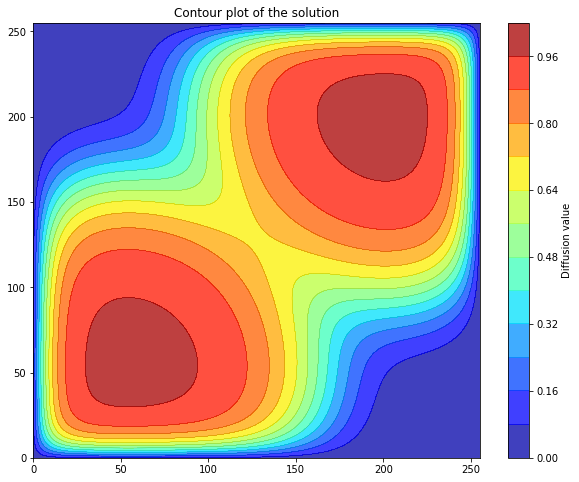

In [13]:
%%px --targets 0:2

# running the simulation
# discretization object
discretization = Discretization(256, 256, 100, 0.01, r=1400, ic=[[50, 50, 0.4],[206, 206, 0.4]])
# the communicator is passed as a parameter of the main function
main(discretization, comm)